In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/AIML/FruitinAmazon.zip" -d "/content/drive/MyDrive/AIML"

Archive:  /content/drive/MyDrive/AIML/FruitinAmazon.zip
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/acai/images (2).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/acai/images (16).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/train/acai/images (3).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/train/acai/images (4).jpeg  
  inflating: /content/drive/MyDrive/AIML/FruitinAmazon/test/graviola/download (1).

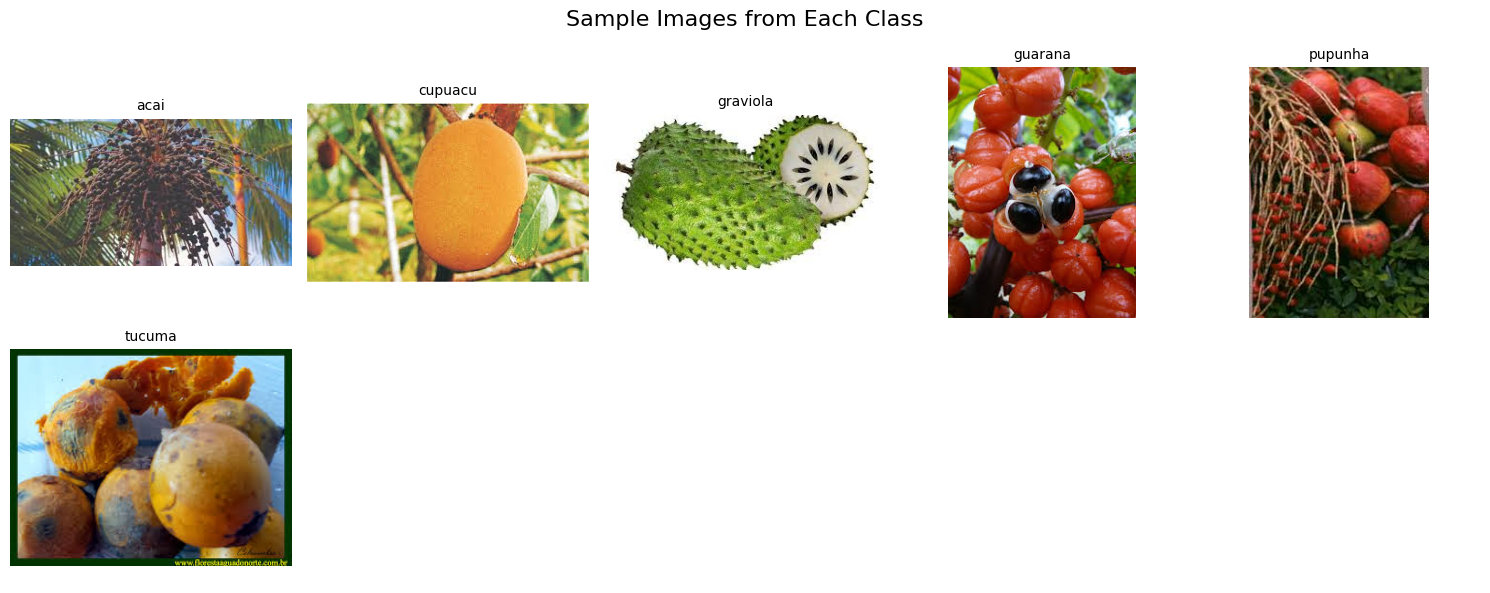

In [4]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_dir = "/content/drive/MyDrive/AIML/FruitinAmazon/train"

class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

if not class_names:
    raise ValueError("No class directories found in the train folder. Check dataset path!")

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    if image_files:
        random_image = random.choice(image_files)
        selected_images.append(os.path.join(class_path, random_image))
        selected_labels.append(class_name)

num_classes = len(selected_images)
if num_classes == 0:
    raise ValueError("No images found in any class folder. Please check dataset.")

cols = min(5, num_classes)
rows = (num_classes // cols) + (num_classes % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i], fontsize=10)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


What did you Observe?

Each image represents a different class, confirming correct dataset structure.
Images vary in resolution, lighting, and orientation.
Some classes may have fewer images, indicating dataset imbalance.
Preprocessing (resizing, normalization) may be needed for consistency.

In [5]:
import os
from PIL import Image
train_dir = "/content/drive/MyDrive/AIML/FruitinAmazon/train"

corrupted_images = []

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:

                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):

                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [6]:
import tensorflow as tf

img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2

rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

val_ds = val_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer='nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'Swornim KC.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.1250 - loss: 1.8971
Epoch 1: val_loss improved from inf to 1.92646, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 852ms/step - accuracy: 0.1250 - loss: 1.9102 - val_accuracy: 0.0000e+00 - val_loss: 1.9265
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.2089 - loss: 1.7236
Epoch 2: val_loss improved from 1.92646 to 1.55303, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 571ms/step - accuracy: 0.2157 - loss: 1.7198 - val_accuracy: 0.7778 - val_loss: 1.5530
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.4039 - loss: 1.5082
Epoch 3: val_loss did not improve from 1.55303
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.4106 - loss: 1.4983 - val_accuracy: 0.0000e+00 - val_loss: 2.3189
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2922 - loss: 1.8494
Epoch 4: val_loss improved from 1.55303 to 1.28655, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 0.3095 - loss: 1.8131 - val_accuracy: 0.7222 - val_loss: 1.2866
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8247 - loss: 1.0916
Epoch 5: val_loss improved from 1.28655 to 1.19671, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 874ms/step - accuracy: 0.8268 - loss: 1.0858 - val_accuracy: 0.7222 - val_loss: 1.1967
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.7795 - loss: 0.9257
Epoch 6: val_loss improved from 1.19671 to 0.99416, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 809ms/step - accuracy: 0.7826 - loss: 0.9202 - val_accuracy: 0.7222 - val_loss: 0.9942
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8744 - loss: 0.5706
Epoch 7: val_loss did not improve from 0.99416
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - accuracy: 0.8780 - loss: 0.5700 - val_accuracy: 0.6111 - val_loss: 1.2010
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8588 - loss: 0.5073
Epoch 8: val_loss improved from 0.99416 to 0.42930, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - accuracy: 0.8663 - loss: 0.5028 - val_accuracy: 0.9444 - val_loss: 0.4293
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8791 - loss: 0.3878
Epoch 9: val_loss did not improve from 0.42930
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.8850 - loss: 0.3804 - val_accuracy: 0.6667 - val_loss: 0.6182
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9392 - loss: 0.2028
Epoch 10: val_loss did not improve from 0.42930
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.9440 - loss: 0.1970 - val_accuracy: 0.8333 - val_loss: 0.6181
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9902 - loss: 0.1198
Epoch 11: val_loss improved from 0.42930 to 0.35790, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step - accuracy: 0.9891 - loss: 0.1166 - val_accuracy: 0.8889 - val_loss: 0.3579
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 1.0000 - loss: 0.0597
Epoch 12: val_loss did not improve from 0.35790
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - accuracy: 1.0000 - loss: 0.0591 - val_accuracy: 0.8889 - val_loss: 0.3795
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 1.0000 - loss: 0.0374
Epoch 13: val_loss did not improve from 0.35790
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 1.0000 - loss: 0.0369 - val_accuracy: 0.8889 - val_loss: 0.3677
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 1.0000 - loss: 0.0185
Epoch 14: val_loss did not improve from 0.35790
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 0.8889 - val_loss: 0.3651
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 1.0000 - loss: 0.0135
Epoch 15: val_loss improved from 0.35790 to 0.34434,

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.8889 - val_loss: 0.3443
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 1.0000 - loss: 0.0094
Epoch 16: val_loss improved from 0.34434 to 0.33340, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 868ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.8889 - val_loss: 0.3334
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 1.0000 - loss: 0.0060
Epoch 17: val_loss did not improve from 0.33340
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 597ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.8889 - val_loss: 0.3386
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 1.0000 - loss: 0.0038
Epoch 18: val_loss improved from 0.33340 to 0.32839, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.8889 - val_loss: 0.3284
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 19: val_loss improved from 0.32839 to 0.32286, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8889 - val_loss: 0.3229
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 20: val_loss improved from 0.32286 to 0.31814, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.8889 - val_loss: 0.3181
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 21: val_loss improved from 0.31814 to 0.31062, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 564ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8889 - val_loss: 0.3106
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 22: val_loss did not improve from 0.31062
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8889 - val_loss: 0.3191
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 23: val_loss did not improve from 0.31062
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8889 - val_loss: 0.3337
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 24: val_loss did not improve from 0.31062
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8889 - val_loss: 0.3427
Epoch 25/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 25: val_loss did not improve from 0.31062
3/3 

In [10]:
test_dir = '/content/drive/MyDrive/AIML/FruitinAmazon/test'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6000 - loss: 240.2258
Test Loss: 240.22584533691406
Test Accuracy: 0.6000000238418579


In [11]:

model.save('Swornim_KC_model.h5')
print("Model saved successfully!")


Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.50      0.60      0.55         5
           2       0.56      1.00      0.71         5
           3       0.75      0.60      0.67         5
           4       0.67      0.40      0.50         5
           5       0.40      0.40      0.40         5

    accuracy                           0.60        30
   macro avg       0.65      0.60      0.60        30
weighted avg       0.65      0.60      0.60        30

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 1: val_loss did not improve from 0.31062
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 617ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8889 - val_loss: 0.3205
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 2: val_loss did not improve from 0.31062
3/3 ━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 947ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8889 - val_loss: 0.3077
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 1.0000 - loss: 9.5579e-04
Epoch 7: val_loss improved from 0.30767 to 0.30340, saving model to Swornim KC.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step - accuracy: 1.0000 - loss: 9.5129e-04 - val_accuracy: 0.8889 - val_loss: 0.3034
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 1.0000 - loss: 7.7294e-04
Epoch 8: val_loss did not improve from 0.30340
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 1.0000 - loss: 7.8229e-04 - val_accuracy: 0.8889 - val_loss: 0.3072
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 1.0000 - loss: 7.7556e-04
Epoch 9: val_loss did not improve from 0.30340
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 1.0000 - loss: 7.7754e-04 - val_accuracy: 0.8889 - val_loss: 0.3170
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 1.0000 - loss: 6.8568e-04
Epoch 10: val_loss did not improve from 0.30340
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 1.0000 - loss: 6.8707e-04 - val_accuracy: 0.8889 - val_loss: 0.3245
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 1.0000 - loss: 6.2082e-04
Epoch 11: val_loss did n

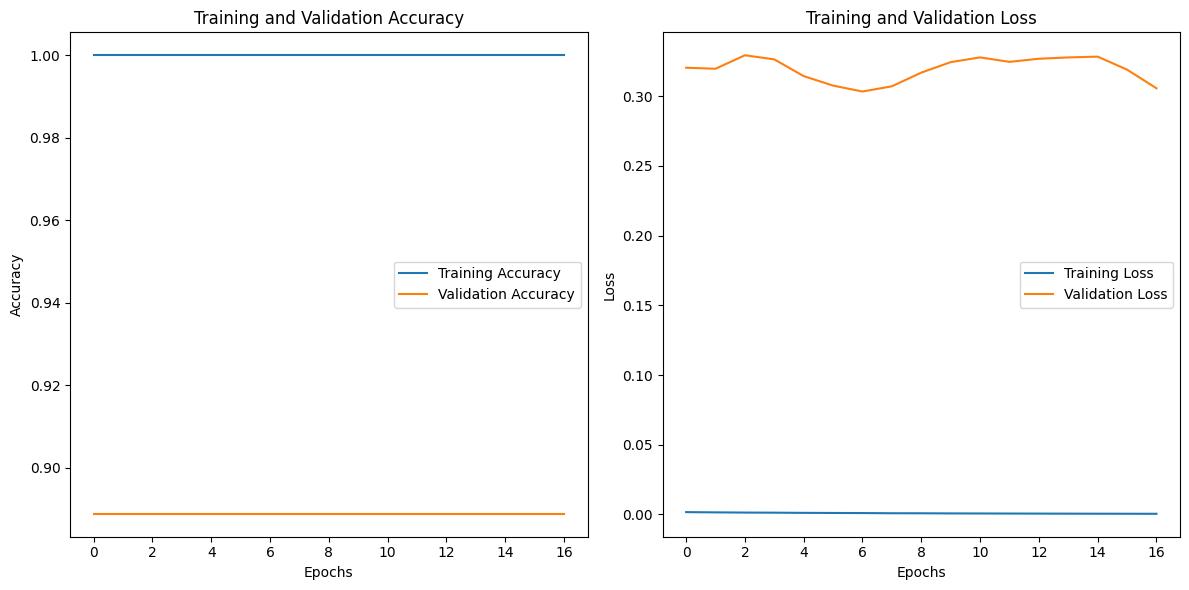

Model saved as 'Swornim_KC_model.h5'


In [12]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

test_images, test_labels = [], []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save('Swornim_KC_model.h5')
print("Model saved as 'Swornim_KC_model.h5'")
